In [19]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import gc
import os
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

warnings.simplefilter('ignore')
%matplotlib inline

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [2]:
seed = 2021

In [3]:
# 读取数据
df_feature = pd.read_pickle('data/feature.pkl')

In [4]:
df_feature.head()

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,issueDate,isDefault,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDate_year,earliesCreditLine_year,issueDate_year_earliesCreditLine_year_minus,debt_ratio_year,applicationType_cnt,employmentLength_cnt,employmentTitle_cnt,grade_cnt,homeOwnership_cnt,initialListStatus_cnt,postCode_cnt,purpose_cnt,regionCode_cnt,subGrade_cnt,title_cnt,verificationStatus_cnt,applicationType_employmentLength_cnt,applicationType_employmentTitle_cnt,applicationType_grade_cnt,applicationType_homeOwnership_cnt,applicationType_initialListStatus_cnt,applicationType_postCode_cnt,applicationType_purpose_cnt,applicationType_regionCode_cnt,applicationType_subGrade_cnt,applicationType_title_cnt,applicationType_verificationStatus_cnt,employmentLength_applicationType_cnt,employmentLength_employmentTitle_cnt,employmentLength_grade_cnt,employmentLength_homeOwnership_cnt,employmentLength_initialListStatus_cnt,employmentLength_postCode_cnt,employmentLength_purpose_cnt,employmentLength_regionCode_cnt,employmentLength_subGrade_cnt,employmentLength_title_cnt,employmentLength_verificationStatus_cnt,employmentTitle_applicationType_cnt,employmentTitle_employmentLength_cnt,employmentTitle_grade_cnt,employmentTitle_homeOwnership_cnt,employmentTitle_initialListStatus_cnt,employmentTitle_postCode_cnt,employmentTitle_purpose_cnt,employmentTitle_regionCode_cnt,employmentTitle_subGrade_cnt,employmentTitle_title_cnt,employmentTitle_verificationStatus_cnt,grade_applicationType_cnt,grade_employmentLength_cnt,grade_employmentTitle_cnt,grade_homeOwnership_cnt,grade_initialListStatus_cnt,grade_postCode_cnt,grade_purpose_cnt,grade_regionCode_cnt,grade_subGrade_cnt,grade_title_cnt,grade_verificationStatus_cnt,homeOwnership_applicationType_cnt,homeOwnership_employmentLength_cnt,homeOwnership_employmentTitle_cnt,homeOwnership_grade_cnt,homeOwnership_initialListStatus_cnt,homeOwnership_postCode_cnt,homeOwnership_purpose_cnt,homeOwnership_regionCode_cnt,homeOwnership_subGrade_cnt,homeOwnership_title_cnt,homeOwnership_verificationStatus_cnt,initialListStatus_applicationType_cnt,initialListStatus_employmentLength_cnt,initialListStatus_employmentTitle_cnt,initialListStatus_grade_cnt,initialListStatus_homeOwnership_cnt,initialListStatus_postCode_cnt,initialListStatus_purpose_cnt,initialListStatus_regionCode_cnt,initialListStatus_subGrade_cnt,initialListStatus_title_cnt,initialListStatus_verificationStatus_cnt,postCode_applicationType_cnt,postCode_employmentLength_cnt,postCode_employmentTitle_cnt,postCode_grade_cnt,postCode_homeOwnership_cnt,postCode_initialListStatus_cnt,postCode_purpose_cnt,postCode_regionCode_cnt,postCode_subGrade_cnt,postCode_title_cnt,postCode_verificationStatus_cnt,purpose_applicationType_cnt,purpose_employmentLength_cnt,purpose_employmentTitle_cnt,purpose_grade_cnt,purpose_homeOwnership_cnt,purpose_initialListStatus_cnt,purpose_postCode_cnt,purpose_regionCode_cnt,purpose_subGrade_cnt,purpose_title_cnt,purpose_verificationStatus_cnt,regionCode_applicationType_cnt,regionCode_employmentLength_cnt,regionCode_employmentTitle_cnt,regionCode_grade_cnt,regionCode_homeOwnership_cnt,regionCode_initialListStatus_cnt,regionCode_postCode_cnt,regionCode_purpose_cnt,regionCode_subGrade_cnt,regionCode_title_cnt,regionCode_verificationStatus_cnt,subGrade_applicationType_cnt,subGrade_employmentLength_cnt,subGrade_employmentTitle_cnt,subGrade_grade_cnt,subGrade_homeOwnership_cnt,subGrade_initialListStatus_cnt,subGrade_postCode_cnt,subGrade_purpose_cnt,subGrade_regionCode_cnt,subGrade_title_cnt,subGrade_verificationStatus_cnt,title_applicationType_cnt,title_employmentLength_cnt,title_employmentTitle_cnt,title_grade_cnt,title_homeOwnership_cnt,title_initi

In [5]:
for f in df_feature.select_dtypes('object').columns:
    lbl = LabelEncoder()
    df_feature[f] = lbl.fit_transform(df_feature[f].astype(str))

In [6]:
# 划分训练集和测试集
df_train = df_feature[df_feature.isDefault.notna()].copy()
df_test = df_feature[df_feature.isDefault.isna()].copy()

df_train.shape, df_test.shape

((800000, 338), (200000, 338))

In [7]:
ycol = 'isDefault'
# feature_names存储各属性特征名
feature_names = list(filter(lambda x: x not in [ycol, 'id'], df_train.columns))

# lgb分类器
model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt',
                           num_leaves=32,
                           max_depth=6,
                           learning_rate=0.05,
                           n_estimators=10000,
                           subsample=0.8,
                           feature_fraction=0.6,
                           reg_alpha=10,
                           reg_lambda=12,
                           random_state=seed,
                           is_unbalance=True,
                           metric='auc')

# 定义df_oof存储训练集预测结果
df_oof = df_train[['id', ycol]].copy()
df_oof['prob'] = 0
# 定义prediction存储测试集预测结果
prediction = df_test[['id']]
prediction['prob'] = 0
# 权重列表
df_importance_list = []

# StratifiedKFold 将df_train和df_test做有放回抽样，随机分5次，取出索引
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train[feature_names], df_train[ycol])):
    # 根据索引取出对应的训练样本数据
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]
    # 根据索引取出对应的评估样本数据
    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(fold_id + 1))
    
# 模型训练
    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=100,
                          early_stopping_rounds=50)
    
    # df_oof存储训练集集预测结果
    pred_val = lgb_model.predict_proba(X_val, num_iteration=lgb_model.best_iteration_)[:, 1]
    df_oof.loc[val_idx, 'prob'] = pred_val
    
    # df_oof存储测试集集预测结果
    pred_test = lgb_model.predict_proba(df_test[feature_names], num_iteration=lgb_model.best_iteration_)[:, 1]
    prediction['prob'] += pred_test / kfold.n_splits
    
    # df_importance存储特征权重
    df_importance = pd.DataFrame({'column': feature_names,'importance': lgb_model.feature_importances_,})
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()


Fold_1 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.739977	valid's auc: 0.733702
[200]	train's auc: 0.748034	valid's auc: 0.737838
[300]	train's auc: 0.753591	valid's auc: 0.73965
[400]	train's auc: 0.758072	valid's auc: 0.740495
[500]	train's auc: 0.761974	valid's auc: 0.740841
[600]	train's auc: 0.765677	valid's auc: 0.741131
[700]	train's auc: 0.76912	valid's auc: 0.74134
[800]	train's auc: 0.772484	valid's auc: 0.741484
Early stopping, best iteration is:
[790]	train's auc: 0.772197	valid's auc: 0.741512

Fold_2 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.740052	valid's auc: 0.733

In [15]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg('mean').sort_values(ascending=False).reset_index()
df_importance

,column,importance
0,issueDate,960.2
1,revolBal,679.0
2,debt_ratio_year,572.8
3,annualIncome,555.2
4,revolUtil,531.8
5,dti,525.8
6,loanAmnt,476.6
7,installment,392.0
8,issueDate_year_earliesCreditLine_year_minus,368.0
9,totalAcc,362.6


<AxesSubplot:xlabel='importance', ylabel='column'>

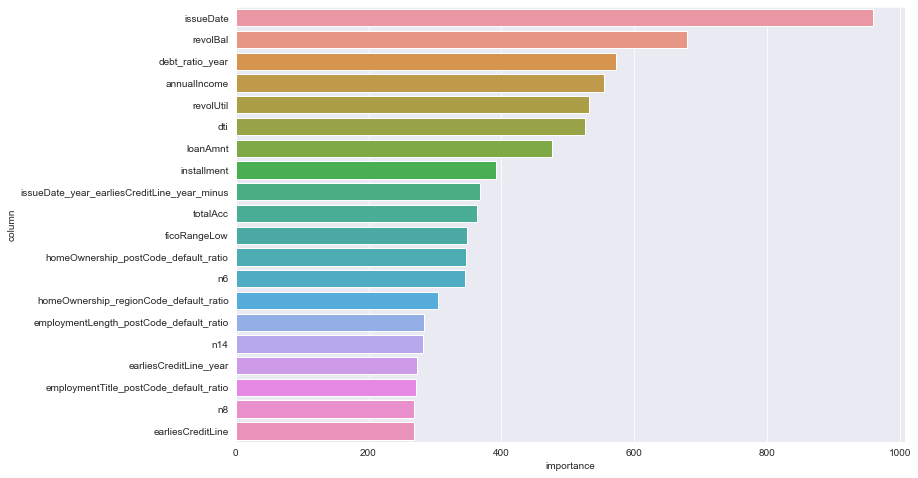

In [16]:
# 特征重要性top20，重要性均超过250
importance_top20=df_importance.sort_values("importance",ascending=False).head(20)
plt.figure(figsize=(12,8))
sns.set_style("darkgrid")
sns.barplot(x="importance",y="column",data=importance_top20,orient="h")

In [24]:
# 计算ROC曲线
fpr, tpr, thresholds = metrics.roc_curve(df_oof[ycol], df_oof['prob'])
# 准确率
auc = metrics.auc(fpr, tpr)
print('auc:', auc)

auc: 0.7425829070709359


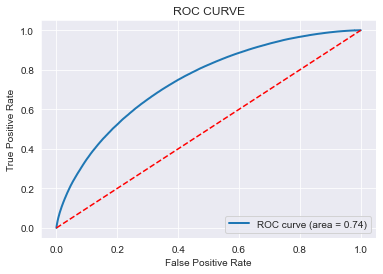

In [26]:
# 绘制ROC曲线
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0,1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc='lower right')
plt.show()

In [10]:
# 打印保存输出结果
os.makedirs('sub', exist_ok=True)

sub = prediction[['id', 'prob']].copy()
sub.columns = ['id', 'isDefault']
sub.to_csv('sub/auc_{}.csv'.format(auc), index=False)

os.makedirs('prob', exist_ok=True)

prediction.to_csv('prob/test_results_lgb.csv', index=False)
df_oof[['id', 'prob', ycol]].to_csv('prob/train_results_lgb.csv', index=False)

In [12]:
df_oof.head()

,id,isDefault,prob
0,7,0.0,0.570539
1,18,1.0,0.510773
2,20,0.0,0.737982
3,36,1.0,0.632016
4,38,1.0,0.764230


In [13]:
prediction.head()

,id,prob
800000,800000,0.215673
800001,800001,0.627685
800002,800002,0.590276
800003,800003,0.619343
800004,800004,0.700241
